In [1]:
import os 
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI

openai_model = ChatOpenAI(model="gpt-4o-mini")
gemini_model = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

In [3]:
from typing import Any, Dict, List, TypedDict

class OverallState(TypedDict):
    input_example: str
    output_example: str 
    original_prompt: str
    context: str 
    candidate_prompts: List[str]
    outputs: Dict[str, Dict[str, Any]]
    evaluations: Dict[str, Dict[str, Any]]
    optimized_prompt: str
    prompt_to_test: str
    dashboard_data: str 
    total_tokens: str 
    feedback: str 
    prompt_versions: List[str]
    current_version: str
    counter: int
    models_list: List[Dict[str, str]]


In [4]:
def prompt_selector_node(state: OverallState):
    prompt_to_test = state.get("optimized_prompt") or state.get("original_prompt")
    return {"prompt_to_test": prompt_to_test}

In [5]:
from typing import TypedDict

class TesterState(TypedDict):
    input_prompt: str
    instruction: str 
    models_list: List[Dict[str, str]]
    model_0_output: Dict[str, Any] #include output, token usage, latency
    model_1_output: Dict[str, Any] #include output, token usage, latency
    model_2_output: Dict[str, Any]
    


In [6]:
from langchain_core.messages import HumanMessage, SystemMessage
from time import time
from langchain.chat_models import init_chat_model

def model_0_tester_node(state: TesterState):
    input_prompt = state.get('input_prompt', '')
    instruction = state.get('instruction', '')
    models_list = state.get('models_list', {})
    if len(models_list) <= 0:
        return {}  # No model, skip
    model_info = models_list[0]
    model_name = next(iter(model_info))
    provider = model_info[model_name]

    if model_name and provider:
        model = init_chat_model(model=model_name, model_provider=provider)
        messages = [
            SystemMessage(content=instruction),
            HumanMessage(content=input_prompt)
        ]
        start_time = time()
        response = model.invoke(messages)
        end_time = time()

        model_0_output = {}
        model_0_output["output"] = response.content 
        model_0_output["tokens"] = response.usage_metadata["total_tokens"]
        model_0_output["latency"] = round((end_time - start_time), 2)
    
    return {"model_0_output": model_0_output}

In [7]:
def model_1_tester_node(state: TesterState):
    input_prompt = state.get('input_prompt', '')
    instruction = state.get('instruction', '')
    models_list = state.get('models_list', {})
    if len(models_list) <= 1:
        return {}  # No second model, skip
    model_info = models_list[1]
    model_name = next(iter(model_info))
    provider = model_info[model_name]

    if model_name and provider:
        model = init_chat_model(model=model_name, model_provider=provider)
        messages = [
            SystemMessage(content=instruction),
            HumanMessage(content=input_prompt)
        ]
        start_time = time()
        response = model.invoke(messages)
        end_time = time()

        model_1_output = {}
        model_1_output["output"] = response.content 
        model_1_output["tokens"] = response.usage_metadata["total_tokens"]
        model_1_output["latency"] = round((end_time - start_time), 2)
    
    return {"model_1_output": model_1_output}

In [8]:
def model_2_tester_node(state: TesterState):
    input_prompt = state.get('input_prompt', '')
    instruction = state.get('instruction', '')
    models_list = state.get('models_list', {})
    if len(models_list) <= 2:
        return {}  # No third model, skip
    model_info = models_list[2]
    model_name = next(iter(model_info))
    provider = model_info[model_name]

    if model_name and provider:
        model = init_chat_model(model=model_name, model_provider=provider)
        messages = [
            SystemMessage(content=instruction),
            HumanMessage(content=input_prompt)
        ]
        start_time = time()
        response = model.invoke(messages)
        end_time = time()

        model_2_output = {}
        model_2_output["output"] = response.content 
        model_2_output["tokens"] = response.usage_metadata["total_tokens"]
        model_2_output["latency"] = round((end_time - start_time), 2)
    
    return {"model_2_output": model_2_output}

In [9]:
from langgraph.graph import StateGraph, END

prompt_tester_workflow = StateGraph(TesterState)
prompt_tester_workflow.add_node("model_0_tester", model_0_tester_node)
prompt_tester_workflow.add_node("model_1_tester", model_1_tester_node)
prompt_tester_workflow.add_node("model_2_tester", model_2_tester_node)
prompt_tester_workflow.set_entry_point("model_0_tester")
prompt_tester_workflow.set_entry_point("model_1_tester")
prompt_tester_workflow.set_entry_point("model_2_tester")
prompt_tester_workflow.add_edge("model_0_tester", END)
prompt_tester_workflow.add_edge("model_1_tester", END)
prompt_tester_workflow.add_edge("model_2_tester", END)

prompt_tester_graph = prompt_tester_workflow.compile()

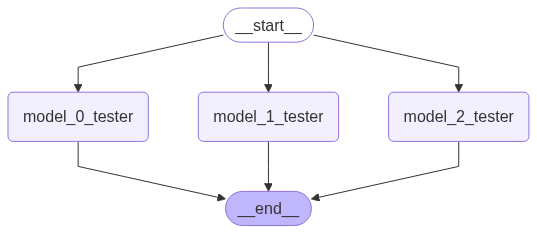

In [10]:
from IPython.display import Image, display

try:
    display(Image(prompt_tester_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [11]:
def prompt_tester_node(state: OverallState):
    prompt = state.get('prompt_to_test')
    input = state.get('input_example', '')
    version = state.get('current_version', 'original')
    outputs = state.get('outputs', {})
    models_list = state.get('models_list', {})

    graph_output = prompt_tester_graph.invoke({"input_prompt": input, "instruction": prompt, "models_list": models_list})

    for idx, model_info in enumerate(models_list):
        model_name = next(iter(model_info))
        result = graph_output.get(f"model_{idx}_output", {})
        if model_name not in outputs:
            outputs[model_name] = {}
        outputs[model_name][version] = result
    # for model_name, result in {
    #     "openai": graph_output.get("openai_output", {}),
    #     "gemini": graph_output.get("gemini_output", {})
    # }.items():
    #     if model_name not in outputs:
    #         outputs[model_name] = {}
    #     outputs[model_name][version] = result

    return {"outputs": outputs}

In [12]:
from pydantic import BaseModel, Field 

class EvaluationScores(BaseModel):
    relevance: float = Field(..., ge=0, le=1, description="The relevance score of the output based on the prompt and context")
    clarity_readability: float = Field(..., ge=0, le=1, description="The clarity or readability score of the output based on the prompt and context")
    tone_match: float = Field(..., ge=0, le=1, description="Score how well does the tone of the output match based on the prompt and context")
    efficiency: float = Field(..., ge=0, le=1, description="The efficiency score of the output based on the prompt and context")
    precision: float = Field(..., ge=0, le=1, description="The precision score of the output based on the prompt and context")
    overall_score: float = Field(..., ge=0, le=1, description="The overall score of the output based on the prompt and context")
    feedback: str = Field(..., description="Feedback on the prompt and suggest changes to the prompt")


In [13]:
EVALUATOR_PROMPT="""
You are an evaluation assistant.

Given the context of the task(if given) and the model's output, score the output on:

{evaluation_schema}

### Context:
{context}

### Example Input:
{input_prompt}

### Prompt:
{instruction}

### Model Output:
{output}
"""

In [14]:
class EvaluatorState(TypedDict):
    instruction: str 
    input_prompt: str
    outputs: Dict[str, Dict[str, Any]]
    context: str 
    models_list: List[Dict[str, str]]
    model_0_eval: Dict[str, Any]
    model_1_eval: Dict[str, Any]
    model_2_eval: Dict[str, Any]

In [33]:
def model_0_evaluator_node(state: EvaluatorState):
    instruction = state.get('instruction', '')
    input_prompt = state.get('input_prompt', '')
    outputs = state.get('outputs', {})
    models_list = state.get('models_list', [])
    if len(models_list) == 0:
        return {}
    model_info = models_list[0]
    model_name = next(iter(model_info))
    provider = model_info[model_name]
    model_outputs = outputs.get(model_name, {})
    if not model_outputs:
        return {}
    version = list(model_outputs.keys())[0]
    context = state.get('context', '')
    output_data = model_outputs[version]

    messages = [
        HumanMessage(
            content=EVALUATOR_PROMPT.format(
                evaluation_schema=EvaluationScores.model_json_schema(),
                context=context, 
                input_prompt=input_prompt, 
                instruction=instruction,
                output=output_data.get('output', '')
            )
        ),
    ]
    model = init_chat_model(model=model_name, model_provider=provider)
    structured_model = model.with_structured_output(EvaluationScores, method="function_calling")
    response = structured_model.invoke(messages)
    # evaluation = response.model_dump_json()
    return {"model_0_eval": response.model_dump()}


In [34]:
def model_1_evaluator_node(state: EvaluatorState):
    instruction = state.get('instruction', '')
    input_prompt = state.get('input_prompt', '')
    outputs = state.get('outputs', {})
    models_list = state.get('models_list', [])
    if len(models_list) <= 1:
        return {}
    model_info = models_list[1]
    model_name = next(iter(model_info))
    provider = model_info[model_name]
    model_outputs = outputs.get(model_name, {})
    if not model_outputs:
        return {}
    version = list(model_outputs.keys())[0]
    context = state.get('context', '')
    output_data = model_outputs[version]

    messages = [
        HumanMessage(
            content=EVALUATOR_PROMPT.format(
                evaluation_schema=EvaluationScores.model_json_schema(), 
                context=context, 
                input_prompt=input_prompt, 
                instruction=instruction,
                output=output_data.get('output', '')
            )
        ),
    ]

    model = init_chat_model(model=model_name, model_provider=provider)
    structured_model = model.with_structured_output(EvaluationScores, method="function_calling")
    response = structured_model.invoke(messages)
    # evaluation = response.model_dump
    return {"model_1_eval": response.model_dump()}

In [35]:
def model_2_evaluator_node(state: EvaluatorState):
    instruction = state.get('instruction', '')
    input_prompt = state.get('input_prompt', '')
    outputs = state.get('outputs', {})
    models_list = state.get('models_list', [])
    if len(models_list) <= 2:
        return {}
    model_info = models_list[2]
    model_name = next(iter(model_info))
    provider = model_info[model_name]
    model_outputs = outputs.get(model_name, {})
    if not model_outputs:
        return {}
    version = list(model_outputs.keys())[0]
    context = state.get('context', '')
    output_data = model_outputs[version]

    messages = [
        HumanMessage(
            content=EVALUATOR_PROMPT.format(
                evaluation_schema=EvaluationScores.model_json_schema(), 
                context=context, 
                input_prompt=input_prompt, 
                instruction=instruction,
                output=output_data.get('output', '')
            )
        ),
    ]

    model = init_chat_model(model=model_name, model_provider=provider)
    structured_model = model.with_structured_output(EvaluationScores, method="function_calling")
    response = structured_model.invoke(messages)
    # evaluation = response.model_dump
    return {"model_2_eval": response.model_dump()}

In [36]:
prompt_eval_workflow  = StateGraph(EvaluatorState)
prompt_eval_workflow.add_node("model_0_evaluator", model_0_evaluator_node)
prompt_eval_workflow.add_node("model_1_evaluator", model_1_evaluator_node)
prompt_eval_workflow.add_node("model_2_evaluator", model_2_evaluator_node)
prompt_eval_workflow.set_entry_point("model_0_evaluator")
prompt_eval_workflow.set_entry_point("model_1_evaluator")
prompt_eval_workflow.set_entry_point("model_2_evaluator")
prompt_eval_workflow.add_edge("model_0_evaluator", END)
prompt_eval_workflow.add_edge("model_1_evaluator", END)
prompt_eval_workflow.add_edge("model_2_evaluator", END)

prompt_eval_graph = prompt_eval_workflow.compile()

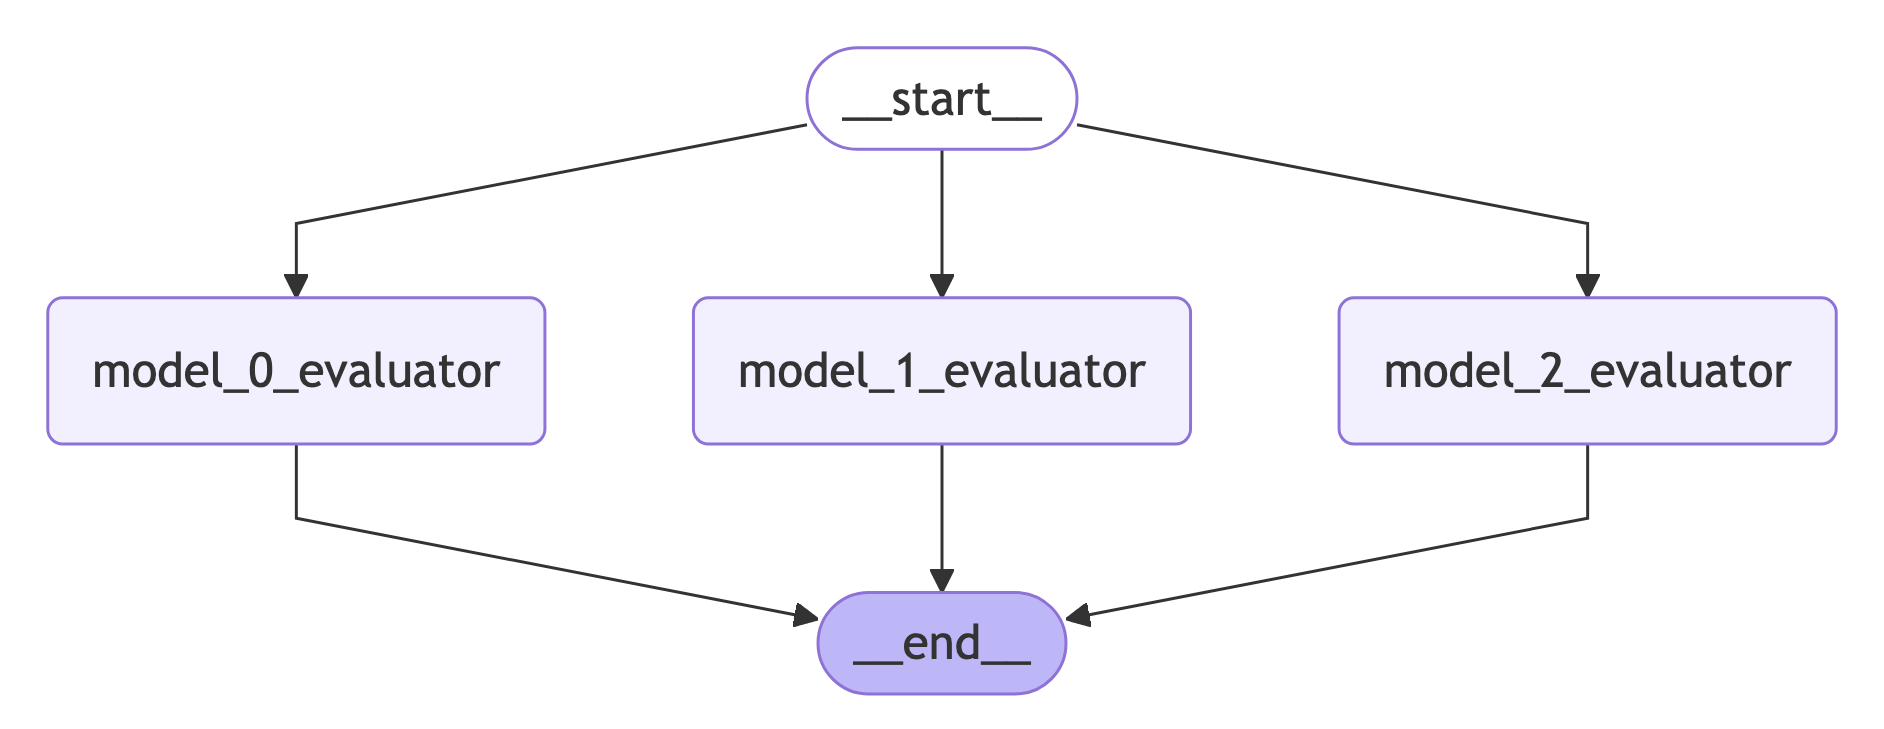

In [37]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
import nest_asyncio 
nest_asyncio.apply()

try:
    display(Image(prompt_eval_graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER), width=400))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [38]:
def prompt_evaluator_node(state: OverallState):
    instruction = state.get('prompt_to_test', '')
    input_example = state.get('input_example', '')
    context = state.get('context')
    outputs = state.get('outputs', {})
    version = state.get('current_version', 'original')
    evaluations = state.get('evaluations', {})
    models_list = state.get('models_list', [])

    graph_input = {
        "instruction": instruction,
        "input_prompt": input_example,
        "context": context,
        "outputs": {
            model_name: {version: outputs.get(model_name, {}).get(version, {})}
            for model_info in models_list
            for model_name in model_info
        },
        "models_list": models_list
    }

    results = prompt_eval_graph.invoke(graph_input)

    for idx, model_info in enumerate(models_list):
        model_name = next(iter(model_info))
        eval_key = f"model_{idx}_eval"
        eval_data = results.get(eval_key)
        if eval_data is not None:
            if model_name not in evaluations:
                evaluations[model_name] = {}
            if hasattr(eval_data, "model_dump"):
                evaluations[model_name][version] = eval_data.model_dump()
            else:
                evaluations[model_name][version] = eval_data
    # evaluation_results = {
    #     "openai": results.get('openai_eval'),
    #     "gemini": results.get('gemini_eval')
    # }
    # print("Evaluation_results: ", evaluation_results)

    # for model_name, eval_data in evaluation_results.items():
    #     if model_name not in evaluations:
    #         evaluations[model_name] = {}
    #     evaluations[model_name][version] = eval_data.model_dump() 

    return {"evaluations": evaluations}

    

In [39]:
from typing import Literal
from langgraph.types import Command
def routing_node(state: AgentState) -> Command[Literal["optimizer", "__end__"]]:
    counter = state.get("counter", 0)
    max_retries = 2
    if counter < max_retries:
        goto = "optimizer"
    else:
        goto = "__end__"
    return Command(
        update={

            "counter": counter + 1
        },
        goto=goto
    )

NameError: name 'AgentState' is not defined

In [ ]:
def routing_function(state: OverallState):
    counter = state.get("counter", 0)
    max_retries = 2
    return counter < max_retries
    

In [ ]:
OPTIMIZER_PROMPT="""
You are a expert prompt engineer. Your job is optimize the given prompt based on the context and evaluation.ONLY OUTPUT THE OPTIMIZED PROMPT.

### Prompt: 
{prompt}

### Context:
{context}

### Evaluation:
{evaluations}
"""

In [ ]:
def optimizer_node(state: OverallState):
    previous_prompt = state.get('prompt_to_test', state.get('original_prompt'))
    context = state.get('context', '')
    evaluations = state.get('evaluations', {})
    current_version = state.get('current_version', 'original')
    counter = state.get("counter", 0)

    # Extract evaluations only for the current version
    current_evals = {
        model: model_evals.get(current_version, {})
        for model, model_evals in evaluations.items()
        if current_version in model_evals
    }

    messages = [
        SystemMessage(content=OPTIMIZER_PROMPT.format(prompt=previous_prompt, context=context, evaluations=current_evals))
    ]
    response = openai_model.invoke(messages)
    new_prompt = response.content 

    # Determine new version name
    prompt_versions = state.get('prompt_versions', ['original'])
    new_version = f'optimized_{len(prompt_versions)}'

    # Update state
    updated_versions = prompt_versions + [new_version]
    updated_candidates = state.get("candidate_prompts", []) + [new_prompt]

    return {
        "optimized_prompt": new_prompt,
        "prompt_versions": updated_versions,
        "candidate_prompts": updated_candidates,
        "prompt_to_test": new_prompt,
        "current_version": new_version,
        "counter": counter + 1
    }

In [ ]:
from langgraph.graph import StateGraph, END

graph_builder = StateGraph(OverallState)
graph_builder.add_node("prompt_selector", prompt_selector_node)
graph_builder.add_node("prompt_tester", prompt_tester_node)
graph_builder.add_node("prompt_evaluator", prompt_evaluator_node)
graph_builder.add_node("prompt_optimizer", optimizer_node)
graph_builder.set_entry_point("prompt_selector")
graph_builder.add_edge("prompt_selector", "prompt_tester")
graph_builder.add_edge("prompt_tester", "prompt_evaluator")
graph_builder.add_conditional_edges("prompt_evaluator", routing_function, {True: "prompt_optimizer", False: END})
graph_builder.add_edge("prompt_optimizer", "prompt_tester")

graph = graph_builder.compile()

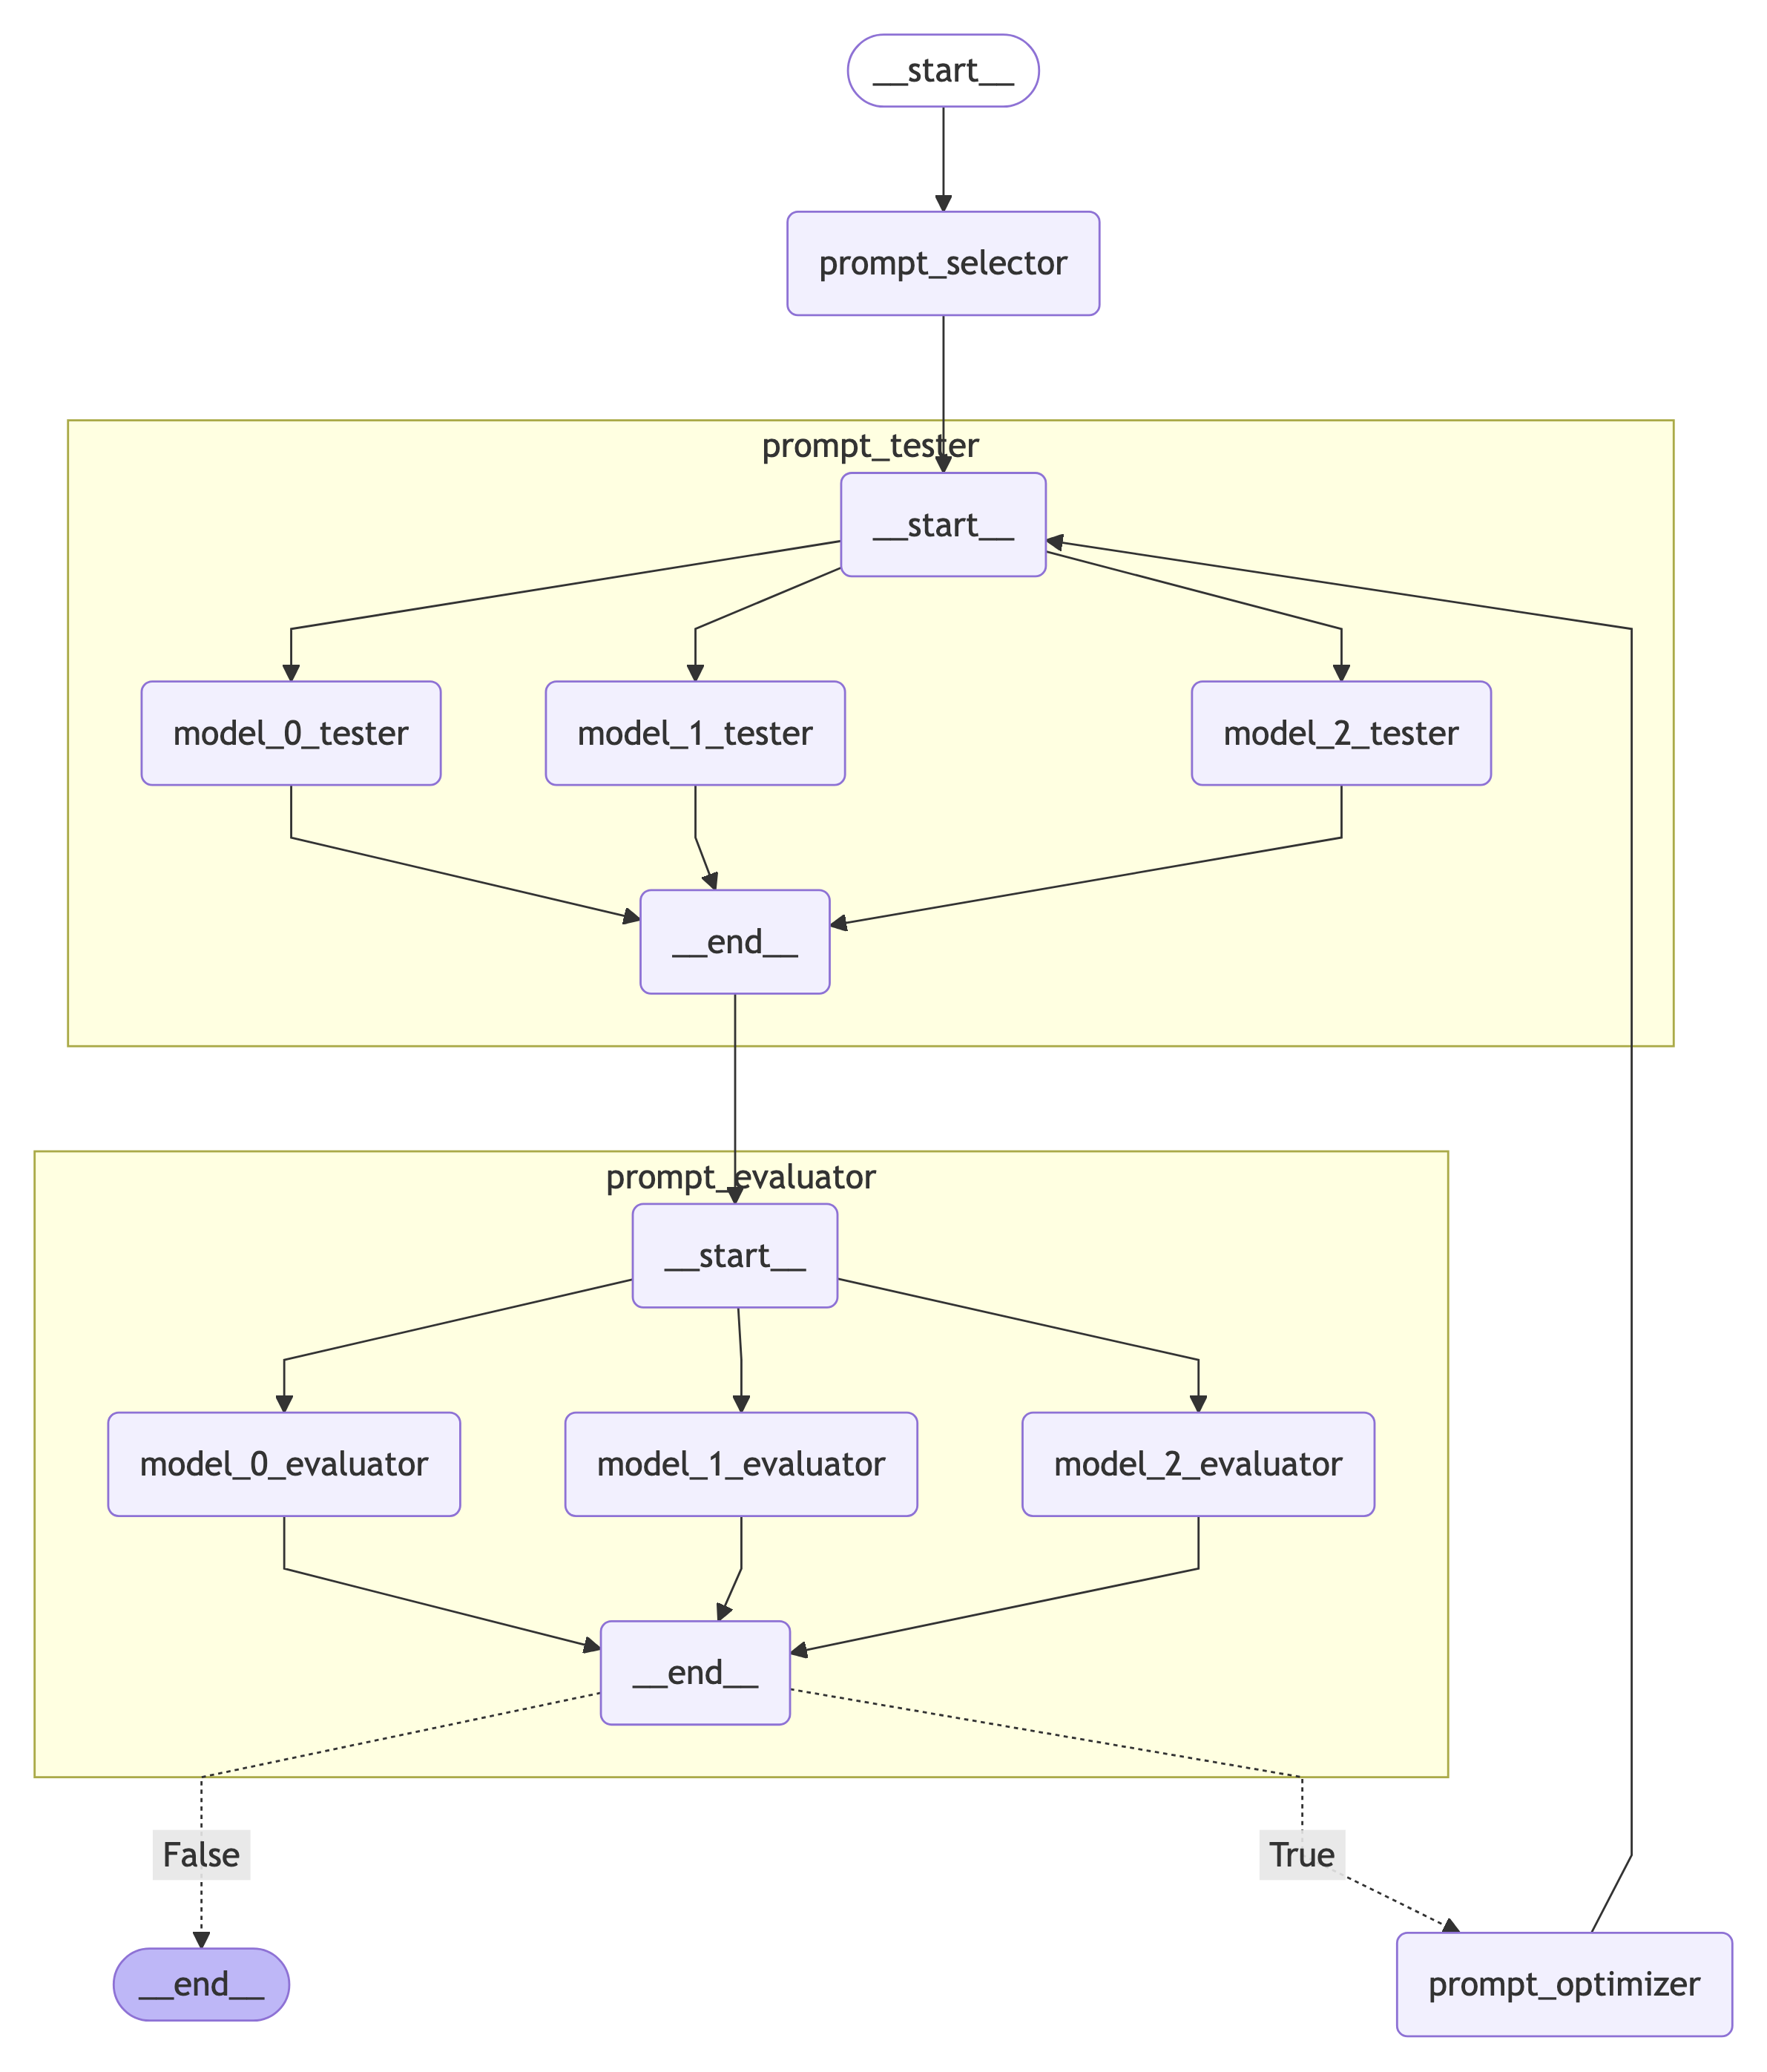

In [40]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
import nest_asyncio 
nest_asyncio.apply()

display(
    Image(
        data=graph.get_graph(xray=1).draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER),
        width=400
    )
)
# print(graph.get_graph(xray=1).draw_mermaid())



In [41]:
inputs = {
    "original_prompt": "Teach the given topic from the user.",
    "input_example": "What is gravity?",
    "context": "A middle school teaching agent used to teach complex topics to middle school kids.",
    "models_list": [{"gpt-4o-mini": "openai"}, {"gemini-2.0-flash": "google-genai"}]
}

result = graph.invoke(inputs)

In [ ]:

evaluations = {
    "openai": {
      "original": {
        "relevance": 0.9,
        "clarity_readability": 0.8,
        "tone_match": 0.7,
        "efficiency": 0.9,
        "precision": 0.8,
        "overall_score": 0.8,
        "feedback": "The answer provides an in-depth explanation of gravity, which is excellent for understanding the topic. However, considering the target audience of middle school students, it may be beneficial to simplify some of the concepts, particularly the equations and theories, or provide analogies that relate to their everyday experiences."
      },
      "optimized_1": {
        "relevance": 1,
        "clarity_readability": 1,
        "tone_match": 1,
        "efficiency": 1,
        "precision": 1,
        "overall_score": 1,
        "feedback": "The explanation is well-structured, using simple language and relatable examples that middle school students can easily understand. No changes needed."
      },
      "optimized_2": {
        "relevance": 1,
        "clarity_readability": 1,
        "tone_match": 1,
        "efficiency": 1,
        "precision": 1,
        "overall_score": 1,
        "feedback": "The explanation is well-suited for middle school students, using relatable examples and simple language. It covers the key aspects of gravity comprehensively, including common misconceptions, and maintains an engaging tone."
      }
    },
    "gemini": {
      "original": {
        "relevance": 1,
        "clarity_readability": 0.9,
        "tone_match": 1,
        "efficiency": 0.8,
        "precision": 1,
        "overall_score": 0.9,
        "feedback": "The explanation is very thorough and well-organized, suitable for middle schoolers. The use of analogies like the bowling ball on a trampoline is helpful. However, the mathematical formula might be too complex for some middle school students. Consider simplifying or omitting it for a broader audience."
      },
      "optimized_1": {
        "relevance": 1,
        "clarity_readability": 0.9,
        "tone_match": 1,
        "efficiency": 0.8,
        "precision": 0.9,
        "overall_score": 0.95,
        "feedback": "The explanation is very clear and uses relatable examples. It effectively simplifies the concept of gravity for middle school students. The analogy of the trampoline and bowling ball is excellent. The only suggestion would be to maybe add a small section addressing common misconceptions about gravity."
      },
      "optimized_2": {
        "relevance": 1,
        "clarity_readability": 0.9,
        "tone_match": 1,
        "efficiency": 0.8,
        "precision": 0.95,
        "overall_score": 0.9,
        "feedback": "The explanation is very clear and uses relatable examples. It effectively addresses common misconceptions. However, it could be slightly more concise without losing essential information."
      }
    }
  }


In [ ]:
scores = []
for model_evals in evaluations.values():
    eval_data = model_evals.get('optimized_1', {})
    score = eval_data.get("overall_score")
    if isinstance(score, (float, int)):
        scores.append(score)

In [ ]:
scores